In [25]:
import os, json, glob, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.ndimage

sys.path.append('./pyusct/')
from rfdata import RFdata

%matplotlib inline


### parameters

In [26]:
# パラメータ設定保存
p = {
    "input": {
        "path" : "/mnt/nas/nb_usctsim/sim_001/",
        "offset": {
            "min": -100, 
            "max":100, 
            "interval":1
        }
    },
    "output" : {
        "path" : "/mnt/nas/PYUSCT_train/dataset004/",
        "num_sampling" : 1000,
        "radius":4,
        "sigma" : 3
    }
}


In [27]:
sim_result_dirs = glob.glob( os.path.join(p["input"]["path"], "trial*"))
sim_result_dirs.sort()
sim_result_dirs = sim_result_dirs[:1]
sim_result_dirs

['/mnt/nas/nb_usctsim/sim_001/trial_001']

In [28]:
# 出力先ディレクトリ
if not os.path.exists(out_dir): 
    os.makedirs(os.path.join(out_dir, "input"))   # 入力データ
    os.makedirs(os.path.join(out_dir, "output"))  # 出力データ      

In [29]:
out_dir = p["output"]["path"]
with open(os.path.join(out_dir,"param.json"), 'w') as outf:
    json.dump(p, outf, indent=4)

### 教師データ生成

In [30]:
offsets = np.arange(
    p["input"]["offset"]["min"],
    p["input"]["offset"]["max"], 
    p["input"]["offset"]["interval"])

def func_mask(rf):
    return (np.linalg.norm(rf.mesh_pos_rcv - rf.mesh_pos_src, axis=2) < rf.param["ringarray"]["radius"]*1.0 )*1

cnt = 0

with open(os.path.join(out_dir, "list.csv"), 'w') as outf: #
    outf.write('id,source,ix,iy,x,y\n')

    for sim_result_dir in sim_result_dirs:

        rf = RFdata(sim_result_dir)
        mask = rf.setTRmask(func_mask)

        r = rf.param["ringarray"]["radius"]*0.8
        x_min, y_min = rf.pos2ngrid( np.array([- r/np.sqrt(2), - r/np.sqrt(2)]))
        x_max, y_max = rf.pos2ngrid( np.array([+ r/np.sqrt(2), + r/np.sqrt(2)]))

        sct_img = scipy.ndimage.gaussian_filter(rf.medium_sct, sigma=p["output"]["sigma"])
        radius = p["output"]["radius"]
        
        for i in range(p["output"]["num_sampling"]): # 出力画像内サンプリング
            
            ix = np.random.randint(x_min, x_max)
            iy = np.random.randint(y_min, y_max)

            out_image = sct_img[iy-radius:iy+radius+1, ix-radius:ix+radius+1]
            _, subset = rf.getPointSubset(np.array([iy, ix]), offsets)

            np.save(os.path.join(os.path.join(out_dir,"input"), '{0:0>6}'.format(i)), subset)
            np.save(os.path.join(os.path.join(out_dir,"output"),'{0:0>6}'.format(i)), out_image)

            x, y = rf.ngrid2pos(np.array([iy, ix]))
            outf.write('{0},{1},{2},{3},{4},{5}\n'.format(cnt, sim_result_dir, ix,iy, x, y))
            cnt += 1

### Appendix

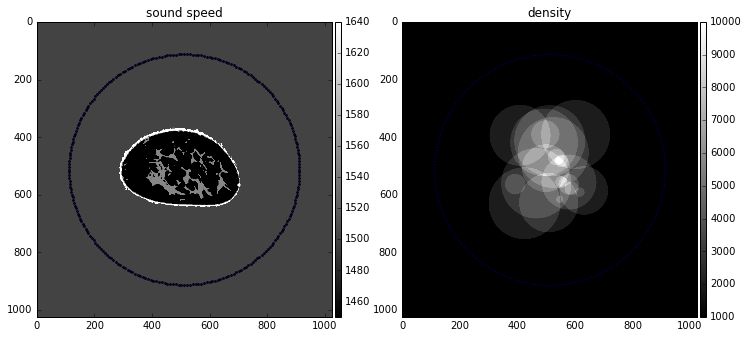

In [19]:
rf.draw_input()

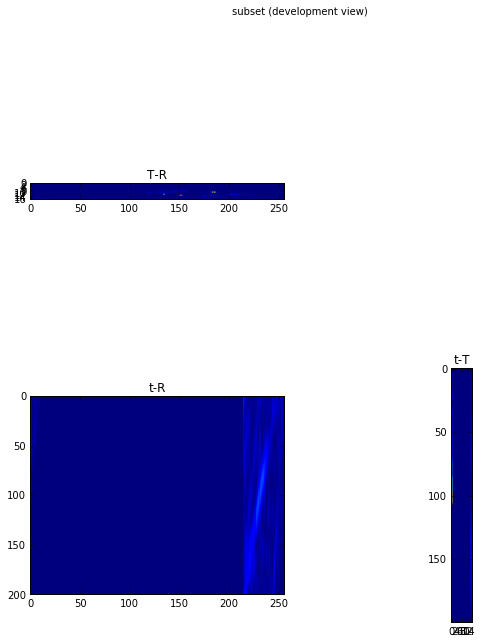

In [20]:
fig = plt.figure(figsize=(10,10))

fig.suptitle("subset (development view)")

plt.subplot(2,2,1)
plt.imshow(subset[:,:,0])
plt.title('T-R')

plt.subplot(2,2,3)
plt.imshow(subset[0,:,:].T)
plt.title('t-R')

plt.subplot(2,2,4)
plt.imshow(subset[:,0,:].T)
plt.title('t-T')

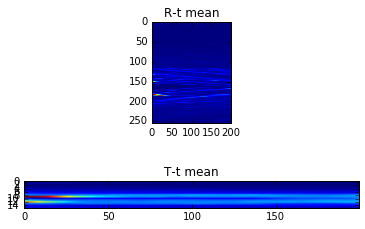

In [21]:
fig.suptitle("subset (1D mean reduction)")

plt.subplot(2,1,1)
plt.imshow(np.mean( subset, axis=0 ))
plt.title('R-t mean')

plt.subplot(2,1,2)
plt.imshow(np.mean(subset, axis=1))
plt.title('T-t mean')

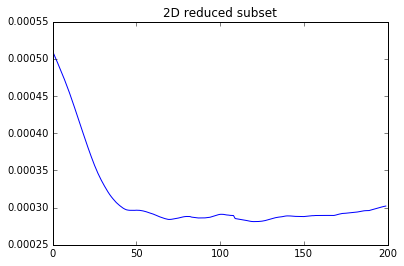

In [22]:
plt.plot(np.mean(np.mean(subset, axis=0), axis=0))
plt.title("2D reduced subset")